In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/Mosaics2_splited.zip' -d '/content/drive/MyDrive/Mosaics2_splited'


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/train/No-Holo/psp_00148/mosa_00118.jpg  
  inflating: /content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/train/No-Holo/psp_00148/mosa_00119.jpg  
  inflating: /content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/train/No-Holo/psp_00148/mosa_00120.jpg  
  inflating: /content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/train/No-Holo/psp_00148/mosa_00121.jpg  
  inflating: /content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/train/No-Holo/psp_00148/mosa_00122.jpg  
  inflating: /content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/train/No-Holo/psp_00148/mosa_00123.jpg  
  inflating: /content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/train/No-Holo/psp_00148/mosa_00124.jpg  
  inflating: /content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/train/No-Holo/psp_00148/mosa_00125.jpg  
  inflating: /content/drive/MyDriv

In [ ]:
pip install tensorflow_hub


In [ ]:
!pip install -U timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import timm

print(torch.__version__)
print(timm.__version__)


2.6.0+cu124
1.0.15


In [ ]:
import os
import torch
import timm
import pickle
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ─── 1) Chemins vers tes dossiers Colab ────────────────────────────────────
train_dir = '/content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/train'
val_dir   = '/content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/validation'
test_dir  = '/content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test'
save_dir  = "vit_small_midvholo_timm"

os.makedirs(save_dir, exist_ok=True)

# ─── 2) Transforms ─────────────────────────────────────────────────────────
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

train_tf = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

eval_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# ─── 3) Datasets & DataLoaders ────────────────────────────────────────────
train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
val_ds   = datasets.ImageFolder(val_dir,   transform=eval_tf)
test_ds  = datasets.ImageFolder(test_dir,  transform=eval_tf)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=4)

# ─── 4) Modèle ViT Small via timm ──────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model(
    'vit_small_patch16_224',
    pretrained=True,
    num_classes=1,
    in_chans=3
)
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, 1),
    nn.Sigmoid()
)
model.to(device)

# ─── 5) Criterion, Optimizer, Scheduler ───────────────────────────────────
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

# ─── 6) Boucle d'entraînement ──────────────────────────────────────────────
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(1, 51):
    # Training
    model.train()
    running_loss = 0.0
    correct = total = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += imgs.size(0)

    val_loss = val_loss / total
    val_acc  = correct / total

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    scheduler.step(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
        print(" → Best model saved.")

# Sauvegarde finale
torch.save(model.state_dict(), os.path.join(save_dir, 'last_model.pth'))
with open(os.path.join(save_dir, 'history.pkl'), 'wb') as f:
    pickle.dump(history, f)

# ─── 7) Courbes d'apprentissage ────────────────────────────────────────────
epochs = list(range(1, 51))

plt.figure(figsize=(12, 6))
sns.lineplot(epochs, history['train_loss'], marker='o')
sns.lineplot(epochs, history['val_loss'],   marker='o')
plt.title("Loss")
plt.legend(['train','val'])
plt.savefig(os.path.join(save_dir, 'loss.png'))
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(epochs, history['train_acc'], marker='o')
sns.lineplot(epochs, history['val_acc'],   marker='o')
plt.title("Accuracy")
plt.legend(['train','val'])
plt.savefig(os.path.join(save_dir, 'accuracy.png'))
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1 [Val]: 100%|██████████| 74/74 [14:16<00:00, 11.57s/it]


Epoch 1: train_loss=0.3713, train_acc=0.8441, val_loss=0.3177, val_acc=0.8769
 → Best model saved.


Epoch 2 [Train]:   2%|▏         | 9/585 [05:30<5:35:32, 34.95s/it]

Test: 100%|██████████| 4680/4680 [28:12<00:00,  2.77it/s]



Test loss: 0.2187, Test accuracy: 0.9598



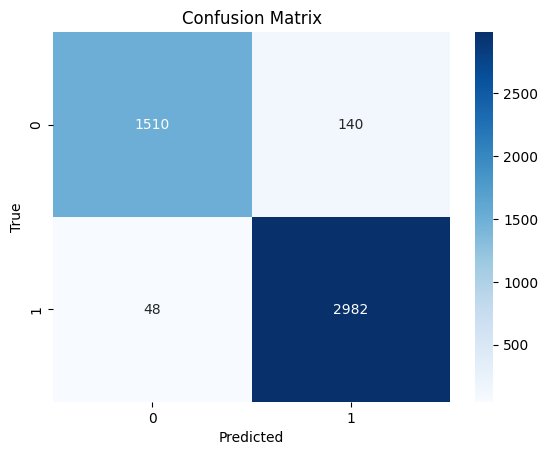

              precision    recall  f1-score   support

         0.0     0.9692    0.9152    0.9414      1650
         1.0     0.9552    0.9842    0.9694      3030

    accuracy                         0.9598      4680
   macro avg     0.9622    0.9497    0.9554      4680
weighted avg     0.9601    0.9598    0.9596      4680



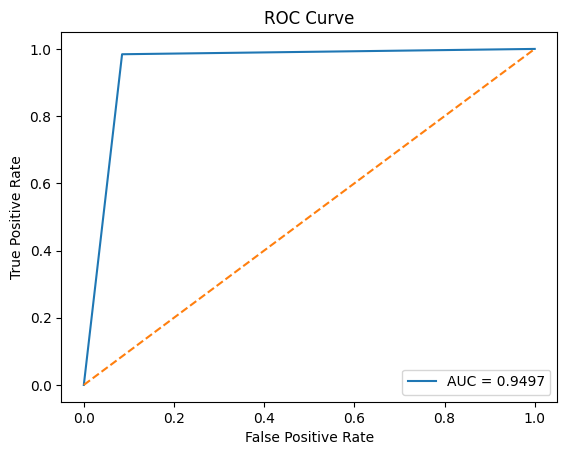

In [ ]:
import os
import torch
import timm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# ─── 1) Chemins ────────────────────────────────────────────────────────────
test_dir = '/content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test'
model_path = '/content/drive/MyDrive/best_model (3).pth'

# ─── 2) Transforms et DataLoader ──────────────────────────────────────────
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

test_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_ds = datasets.ImageFolder(test_dir, transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2)

# ─── 3) Chargement du modèle depuis le chemin ─────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('vit_small_patch16_224', pretrained=False, num_classes=1)
model.head = nn.Sequential(nn.Linear(model.head.in_features, 1), nn.Sigmoid())

# Chargement des poids
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# ─── 4) Évaluation ────────────────────────────────────────────────────────
criterion = nn.BCELoss()
all_preds = []
all_labels = []
losses = []

with torch.no_grad():
    for img, label in tqdm(test_loader, desc="Test"):
        img = img.to(device)
        label = label.float().unsqueeze(1).to(device)

        output = model(img)
        loss = criterion(output, label)
        losses.append(loss.item())

        pred = (output >= 0.5).float()
        all_preds.append(pred.item())
        all_labels.append(label.item())

test_loss = np.mean(losses)
test_acc  = np.mean([p == l for p, l in zip(all_preds, all_labels)])
print(f"\nTest loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}\n")

# ─── 5) Matrice de confusion ──────────────────────────────────────────────
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(os.path.dirname(model_path), 'confusion_matrix.png'))
plt.show()

# ─── 6) Classification Report ─────────────────────────────────────────────
print(classification_report(all_labels, all_preds, digits=4))

# ─── 7) ROC Curve ──────────────────────────────────────────────────────────
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.savefig(os.path.join(os.path.dirname(model_path), 'roc_curve.png'))
plt.show()


test mosaiques


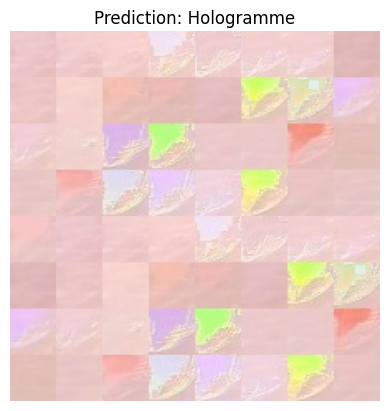

Image: /content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test/Holo/psp_00101/mosa_00030.jpg
Prediction (raw output): 0.0000
Predicted label: Hologramme
--------------------------------------------------


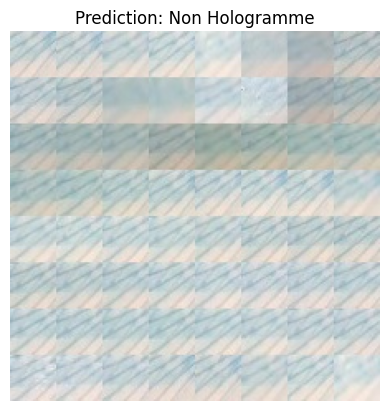

Image: /content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test/No-Holo/psp_00010/mosa_00002.jpg
Prediction (raw output): 1.0000
Predicted label: Non Hologramme
--------------------------------------------------


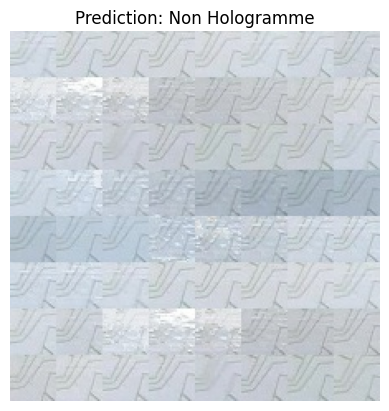

Image: /content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test/No-Holo/psp_00145/mosa_00000.jpg
Prediction (raw output): 1.0000
Predicted label: Non Hologramme
--------------------------------------------------


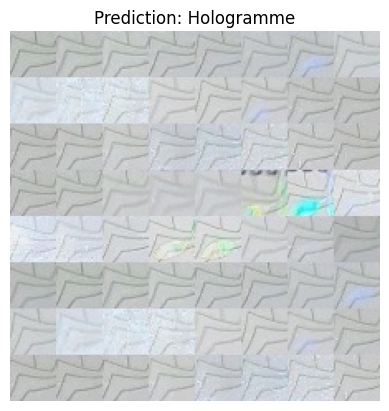

Image: /content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test/Holo/psp_00140/mosa_00008.jpg
Prediction (raw output): 0.0000
Predicted label: Hologramme
--------------------------------------------------


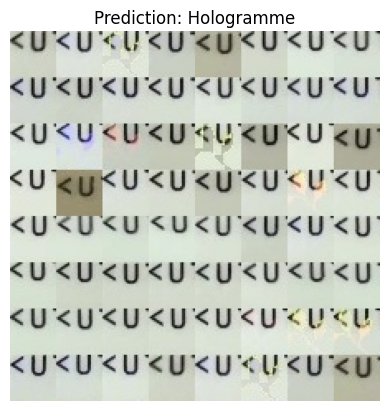

Image: /content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test/Holo/psp_00096/mosa_00094.jpg
Prediction (raw output): 0.0000
Predicted label: Hologramme
--------------------------------------------------


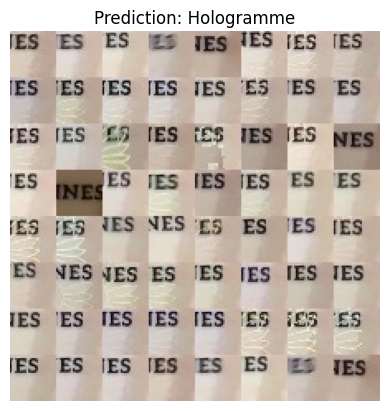

Image: /content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test/Holo/psp_00096/mosa_00065.jpg
Prediction (raw output): 0.0000
Predicted label: Hologramme
--------------------------------------------------


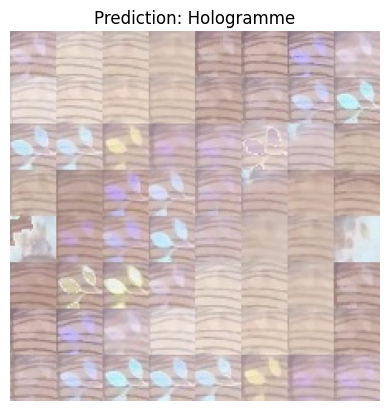

Image: /content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test/Holo/psp_00121/mosa_00006.jpg
Prediction (raw output): 0.0000
Predicted label: Hologramme
--------------------------------------------------


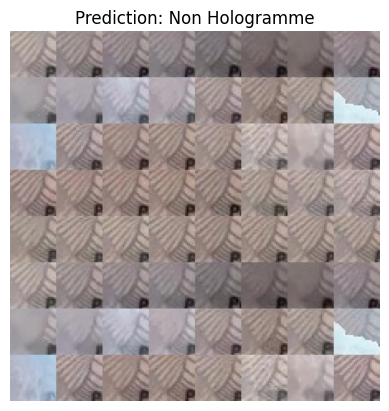

Image: /content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test/No-Holo/psp_00132/mosa_00016.jpg
Prediction (raw output): 1.0000
Predicted label: Non Hologramme
--------------------------------------------------


In [ ]:
import os
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from PIL import Image

# ─── 1) Chemin du modèle et des images à tester ───────────────────────────
image_paths = [
    '/content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test/Holo/psp_00101/mosa_00030.jpg',
    '/content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test/No-Holo/psp_00010/mosa_00002.jpg',
    '/content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test/No-Holo/psp_00145/mosa_00000.jpg',
    '/content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test/Holo/psp_00140/mosa_00008.jpg',
    '/content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test/Holo/psp_00096/mosa_00094.jpg',
    '/content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test/Holo/psp_00096/mosa_00065.jpg',
    '/content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test/Holo/psp_00121/mosa_00006.jpg',
    '/content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test/No-Holo/psp_00132/mosa_00016.jpg'
]
model_path = '/content/drive/MyDrive/best_model (3).pth'

# ─── 2) Transformations des images ────────────────────────────────────────
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

test_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# ─── 3) Chargement du modèle ───────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('vit_small_patch16_224', pretrained=False, num_classes=1)
model.head = nn.Sequential(nn.Linear(model.head.in_features, 1), nn.Sigmoid())

# Chargement des poids du modèle
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# ─── 4) Test sur les images ───────────────────────────────────────────────
for image_path in image_paths:
    # Charger l'image
    img = Image.open(image_path).convert('RGB')

    # Appliquer les transformations
    img_tensor = test_tf(img).unsqueeze(0).to(device)  # Ajouter une dimension de batch

    # Passer l'image dans le modèle
    with torch.no_grad():
        output = model(img_tensor)
        pred = (output >= 0.5).float()  # Classification binaire, seuil 0.5
        pred_label = 'Hologramme' if pred.item() == 0 else 'Non Hologramme'


    # Affichage de l'image et du résultat
    plt.imshow(img)
    plt.title(f"Prediction: {pred_label}")
    plt.axis('off')
    plt.show()

    # Affichage du score de confiance (probabilité)
    print(f"Image: {image_path}")
    print(f"Prediction (raw output): {output.item():.4f}")
    print(f"Predicted label: {pred_label}")
    print('-' * 50)


tester vit

Test: 100%|██████████| 4680/4680 [28:26<00:00,  2.74it/s]



Test loss: 0.7220, Test accuracy: 0.9592



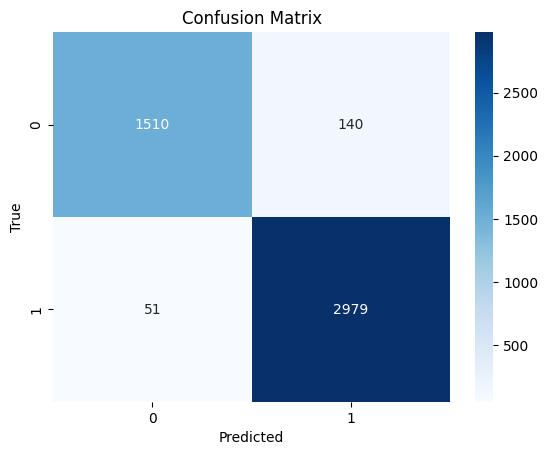

              precision    recall  f1-score   support

         0.0     0.9673    0.9152    0.9405      1650
         1.0     0.9551    0.9832    0.9689      3030

    accuracy                         0.9592      4680
   macro avg     0.9612    0.9492    0.9547      4680
weighted avg     0.9594    0.9592    0.9589      4680



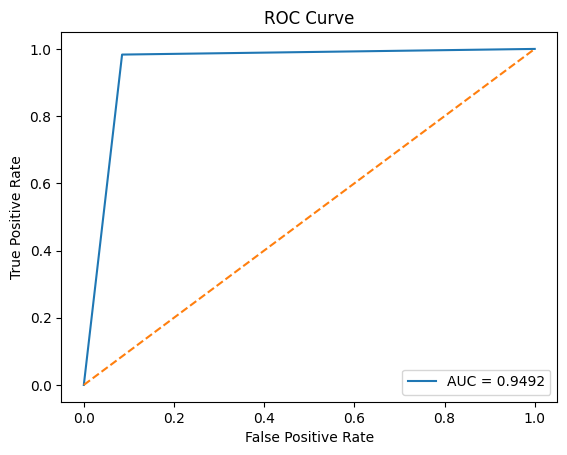

In [ ]:
import os
import torch
import timm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# ─── 1) Chemins ────────────────────────────────────────────────────────────
test_dir = '/content/drive/MyDrive/Mosaics2_splited/Mosaics2_splited/test'
model_path = '/content/drive/MyDrive/vit_small/best_model (4).pth'

# ─── 2) Transforms et DataLoader ──────────────────────────────────────────
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

test_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_ds = datasets.ImageFolder(test_dir, transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2)

# ─── 3) Chargement du modèle depuis le chemin ─────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('vit_small_patch16_224', pretrained=False, num_classes=1)
model.head = nn.Sequential(nn.Linear(model.head.in_features, 1), nn.Sigmoid())

# Chargement des poids
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# ─── 4) Évaluation ────────────────────────────────────────────────────────
criterion = nn.BCELoss()
all_preds = []
all_labels = []
losses = []

with torch.no_grad():
    for img, label in tqdm(test_loader, desc="Test"):
        img = img.to(device)
        label = label.float().unsqueeze(1).to(device)

        output = model(img)
        loss = criterion(output, label)
        losses.append(loss.item())

        pred = (output >= 0.5).float()
        all_preds.append(pred.item())
        all_labels.append(label.item())

test_loss = np.mean(losses)
test_acc  = np.mean([p == l for p, l in zip(all_preds, all_labels)])
print(f"\nTest loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}\n")

# ─── 5) Matrice de confusion ──────────────────────────────────────────────
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(os.path.dirname(model_path), 'confusion_matrix.png'))
plt.show()

# ─── 6) Classification Report ─────────────────────────────────────────────
print(classification_report(all_labels, all_preds, digits=4))

# ─── 7) ROC Curve ──────────────────────────────────────────────────────────
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.savefig(os.path.join(os.path.dirname(model_path), 'roc_curve.png'))
plt.show()
